# Acknowledgements
Due to the lack of information, I do not include Ocean Waves. Until a source is found for its budget and box office, we cannot deduce its return. In addition, since it was a made-for-TV film, it's unlikely a box office number exists.
Any financial information is adjusted for inflation and converted to USD.

# File Importation and Cleaning

We first import common general packages for our calculations.

In [1]:
# General package and data import
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import statsmodels as sm

## Ghibli box office v budget data

This data was collected by scraping interviews, box office report websites, and some social media websites. See further

In [2]:
ghibli = pd.read_csv('ghibli.csv') # Importing our data..
ghibli.dtypes # But we must notice..

movie            object
release_date     object
year              int64
budget          float64
box_office      float64
return          float64
dtype: object

Notice release_date is an object, not a date and time object. We convert for calculations later.

In [3]:
ghibli['release_date'] = pd.to_datetime(ghibli['release_date'])
ghibli.dtypes

movie                   object
release_date    datetime64[ns]
year                     int64
budget                 float64
box_office             float64
return                 float64
dtype: object

## Master table for ghibli variables

| Variable Name | Definition |
|---|---:|
| movie | Movie Name |
| release_date | Initial release date in Japan |
| year | Year of initial release date |
| budget | Reported budget of movie |
| box_office | Sum of reported opening weekend box office across the globe |
| return | (box_office - budget) / budget |

## Google Trends data

Several notes:<br>
This data is only helpful for movies after 2004 as Google Trends only has data from that year onwards.<br>
Interest is a metric representing search frequency. The data was initially on a month-by-month basis but I have averaged them across each year.<br>
Full source here: [Google Trends - studio ghibli](https://trends.google.com/trends/explore?q=studio%20ghibli&date=now%201-d&geo=US&hl=en-US)

In [4]:
# Comparing return to global interest
# Google Trends only has data since 2004, so we proceed from there.
trends = pd.read_csv('ghibli_trends.csv')
trends.head()

,year,interest
0,2004,4.500000
1,2005,4.666667
2,2006,4.750000
3,2007,3.083333
4,2008,3.416667


## Film review aggregator site data

This data is collected from the following website aggregators: IMDB, Rotten Tomatoes, and Metacritic.

| Name | Definition |
|:--|--:|
|IMDB| IMDB rating |
|RT | Rotten Tomatoes critic rating |
|RTU|Rotten Tomatoes user rating|
|MS|Metacritic critic score|
|MSU|Metacritic user score|

In [5]:
ghibli_r = pd.read_csv('ghibli_ratings.csv')
ghibli_r.head()

,movie,release,year,director,genre,IMDB,RT,RTU,MS,MSU
0,Nausicaa,3/11/1984,1984,Hayao Miyazaki,"post-apocalyptic, fantasy",8.0,91,91,86,8.5
1,Castle in the Sky,8/2/1986,1986,Hayao Miyazaki,"fantasy, adventure",8.0,96,91,78,8.5
2,My Neighbor Totoro,4/15/1988,1988,Hayao Miyazaki,fantasy,8.1,94,94,87,8.5
3,Grave of the Fireflies,4/15/1988,1988,Isao Takahata,war,8.5,100,95,94,9.0
4,Kiki's Delivery Service,7/29/1989,1989,Hayao Miyazaki,fantasy,7.8,98,89,85,8.3


However, notice that MSU and IMDB are on different scales compared to the other scores. We normalize these scores to be on the same scale as the others.

In [6]:
ghibli_rs = ghibli_r[['year','movie','IMDB', 'RT', 'RTU', 'MS', 'MSU', 'director', 'genre']] # Reordering variables on the copied dataframe
ghibli_rs.loc[13, 'MSU'] = 7.1 # Typo on 'The Cat Returns' MSU score
ghibli_rs.loc[:, 'IMDB'] *= 10
ghibli_rs.loc[:, 'MSU'] *= 10
ghibli_rs['avg'] = ghibli_rs[['IMDB', 'RT', 'RTU', 'MS', 'MSU']].mean(axis=1)
ghibli_rs = ghibli_rs[['year','movie','IMDB', 'RT', 'RTU', 'MS', 'MSU', 'avg', 'director', 'genre']]
ghibli_rs.sort_values('avg', ascending=False, ignore_index=True)

,year,movie,IMDB,RT,RTU,MS,MSU,avg,director,genre
0,2001,Spirited Away,86.0,96,96,96,90.0,92.8,Hayao Miyazaki,fantasy
1,1988,Grave of the Fireflies,85.0,100,95,94,90.0,92.8,Isao Takahata,war
2,2014,The Tale of Princess Kaguya,80.0,100,90,89,85.0,88.8,Isao Takahata,"historical, fantasy"
3,1988,My Neighbor Totoro,81.0,94,94,87,85.0,88.2,Hayao Miyazaki,fantasy
4,1997,Princess Mononoke,83.0,93,94,78,89.0,87.4,Hayao Miyazaki,"historical, fantasy"
5,1984,Nausicaa,80.0,91,91,86,85.0,86.6,Hayao Miyazaki,"post-apocalyptic, fantasy"
6,1989,Kiki's Delivery Service,78.0,98,89,85,83.0,86.6,Hayao Miyazaki,fantasy
7,2004,Howl's Moving Castle,82.0,88,93,82,86.0,86.2,Hayao Miyazaki,fantasy
8,1991,Only Yesterday,76.0,100,82,90,83.0,86.2,Isao Takahata,drama
9,1986,Castle in the Sky,80.0,96,91,78,85.0,86.0,Hayao Miyazaki,"fantasy, adventure"


We perform final checks for any missing data to confirm our data is then clean. Also, our data is sorted based on average film scores for those curious.

In [7]:
data = [('Ghibli financial',ghibli),('Ghibli trends', trends), ('Ghibli ratings', ghibli_rs)]
for n,x in data:
    print(f"Missing data in {n}: {x.isna().sum().sum()}")

Missing data in Ghibli financial: 0
Missing data in Ghibli trends: 0
Missing data in Ghibli ratings: 0


With that, we proceed! One more reference table to keep track of which dataframe is responsible for what:
|Name|Definition|
|:--|--:|
|ghibli|Financial information for each Ghibli movie|
|trends|Google Trends data about Ghibli movies after 2004|
|ghibli_rs|Standardized ratings for every Ghibli film from major film review aggregators|

# General Statistics

We now construct graphs for general statistics using our variables.

In [8]:
# Box and whisker for box office and return
bo = alt.Chart(ghibli).mark_boxplot().encode(
    y = "box_office",
    tooltip = 'movie').properties(
    height = 200,
    width = 200)
ret = alt.Chart(ghibli).mark_boxplot().encode(
    y = "return:Q",
    tooltip = 'movie').properties(
    height = 200,
    width = 200)
bo | ret

alt.HConcatChart(...)

In [9]:
# Box office over time
box = alt.Chart(ghibli).mark_line(color='green',point=alt.OverlayMarkDef(fill='green')).encode(
    x = "year:T",
    y = "box_office",
    tooltip = ["movie",'box_office'])
box

alt.Chart(...)

In [10]:
# Budget over time
budget = alt.Chart(ghibli).mark_line(color = 'red',point=alt.OverlayMarkDef(fill='red')).encode(
    x = "year:T",
    y = "budget",
    tooltip = ["movie","budget"])
budget

alt.Chart(...)

In [11]:
chart = box + budget
chart.properties(
    width=1000,
    height=500
)

alt.LayerChart(...)

In [12]:
# Box office over budget
box_budget = alt.Chart(ghibli).mark_point().encode(
    x = "budget",
    y = "box_office",
    tooltip = "movie")
box_budget

alt.Chart(...)

# Finding a correlation between finanical variables

In [13]:
import statsmodels.api as sm 
from ISLP.models import (ModelSpec as MS,
    summarize,
    poly)

In [14]:
from sklearn.linear_model import LinearRegression as LR

In [15]:
# Using sklearn
ghibli = ghibli.sort_values("budget")
model = LR(fit_intercept = True)
x = ghibli["budget"].to_numpy()
y = ghibli["box_office"].to_numpy()
x = x[:, np.newaxis]
model.fit(x, y)
lin_coef = model.coef_
lin_int = model.intercept_

In [16]:
xfit = np.linspace(0,70000000,23)
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)
linreg_func = pd.DataFrame({'x':xfit, "y":yfit})

In [17]:
linreg = alt.Chart(linreg_func).mark_line().encode(
    x='x',
    y='y')

linreg + box_budget

alt.LayerChart(...)

In [18]:
from sklearn.metrics import r2_score
print(f"R^2: {r2_score(y, yfit):.4}") 

R^2: 0.1295


This r score is rather weak, therefore we cannot conclude there exists an association between budget and box office for all Studio Ghibli movies.

# Ghibli after 2004
This is relevant because we can then implement our Google Trends data!

In [19]:
ghibli04 = ghibli[ghibli["year"] >= 2004]
ghibli04

,movie,release_date,year,budget,box_office,return
20,When Marnie Was There,2014-07-19,2014,14711411.94,4.847827e+07,2.295283
21,Earwig and the Witch,2021-02-03,2021,23635762.54,8.588610e+05,-0.963663
14,Tales from Earthsea,2006-07-29,2006,30046471.83,1.128394e+08,2.755496
16,Arrietty,2010-07-17,2010,33777011.66,2.119784e+08,5.275818
13,Howl's Moving Castle,2004-11-20,2004,37622834.55,3.835464e+08,9.194512
22,The Boy and the Heron,2023-07-14,2023,38772516.15,2.998717e+08,6.734132
17,From Up On Poppy Hill,2011-07-16,2011,39297028.40,8.811029e+07,1.242162
18,The Wind Rises,2013-07-20,2013,42252844.36,1.923392e+08,3.552101
15,Ponyo,2008-07-19,2008,48911585.63,2.818867e+08,4.763190
19,The Tale of Princess Kaguya,2013-11-23,2013,66521167.01,3.386080e+07,-0.490977


In [20]:
big_box = ghibli04['box_office'].max()
big_ret = ghibli04['return'].max()
trends['bo_s'] = trends['interest'] * (big_box/trends['interest'].max()) # Scaled for visibility on a graph later on

In [21]:
box_return_04 = alt.Chart(ghibli04).mark_point().encode(
    x = "year:T",
    y = "box_office",
    size = "return",
    tooltip = "movie")
box_return_04

alt.Chart(...)

In [23]:
# Overlaying interest over box office performance
ghibli_bo_trending = alt.Chart(trends).mark_line().encode(
    x = 'year',
    y = 'bo_s')
ghibli_bo_trending + box_return_04

alt.LayerChart(...)

It's worth notice that its spike in popularity supposedly happened after <i>When Marnie Was There</i>. This can be interpreted as hype leading up to <i>Boy and the Heron</i> or the results of COVID-19 lockdowns. We are not investigating the cause of this here though.<br>
We create a new dataframe combining these films with trends.

In [24]:
# Construct a dataframe combining ghibli box office with interest
ghibli_int = pd.merge(ghibli04, trends)
ghibli_int

,movie,release_date,year,budget,box_office,return,interest,bo_s
0,When Marnie Was There,2014-07-19,2014,14711411.94,4.847827e+07,2.295283,18.666667,1.147821e+08
1,Earwig and the Witch,2021-02-03,2021,23635762.54,8.588610e+05,-0.963663,36.750000,2.259773e+08
2,Tales from Earthsea,2006-07-29,2006,30046471.83,1.128394e+08,2.755496,4.750000,2.920795e+07
3,Arrietty,2010-07-17,2010,33777011.66,2.119784e+08,5.275818,5.333333,3.279489e+07
4,Howl's Moving Castle,2004-11-20,2004,37622834.55,3.835464e+08,9.194512,4.500000,2.767069e+07
5,The Boy and the Heron,2023-07-14,2023,38772516.15,2.998717e+08,6.734132,61.000000,3.750915e+08
6,From Up On Poppy Hill,2011-07-16,2011,39297028.40,8.811029e+07,1.242162,7.166667,4.406813e+07
7,The Wind Rises,2013-07-20,2013,42252844.36,1.923392e+08,3.552101,14.250000,8.762384e+07
8,Ponyo,2008-07-19,2008,48911585.63,2.818867e+08,4.763190,3.416667,2.100922e+07
9,The Tale of Princess Kaguya,2013-11-23,2013,66521167.01,3.386080e+07,-0.490977,14.250000,8.762384e+07


In [28]:
# Did the interest have any effect on box office performance?
ghibli_int = ghibli_int.sort_values("year")
model2 = LR(fit_intercept = True)
x2 = ghibli_int["bo_s"].to_numpy()
y2 = ghibli_int["box_office"].to_numpy()
x2 = x2[:, np.newaxis]
model2.fit(x2, y2)
lin_coef2 = model2.coef_
lin_int2 = model2.intercept_

In [29]:
x2fit = np.linspace(2004,2025,10)
X2fit = x2fit[:, np.newaxis]
y2fit = model2.predict(X2fit)
linreg_func2 = pd.DataFrame({'x':x2fit, "y":y2fit})

In [30]:
linreg2 = alt.Chart(linreg_func2).mark_line().encode(
    x='x',
    y='y')

linreg2 + box_return_04 + ghibli_bo_trending

alt.LayerChart(...)

In [69]:
print(f"R^2: {r2_score(y2, y2fit):.4}") #LMFAO

R^2: -0.0009793


This provides no evidence that the rise in Ghibli's popularity impacted its box office performance post 2004.
This isn't saying that its rise in popularity didn't impact its performance, we just cannot conclude it did.

# Film review aggregator investigation

In [70]:
ghibli_rs['avg'].mean() # Average score for every Ghibli movie across every website

80.84166666666667

In [71]:
alt.Chart(ghibli_rs).mark_circle().encode(
    x='year:T',
    y='avg')

alt.Chart(...)

In [72]:
ghibli_rs.groupby('director')[['IMDB', 'RT', 'RTU', 'MS', 'MSU', 'avg']].mean()

,IMDB,RT,RTU,MS,MSU,avg
director,,,,,,
Goro Miyazaki,61.333333,50.666667,64.666667,54.666667,60.000000,58.266667
Hayao Miyazaki,79.545455,93.363636,90.090909,85.000000,83.727273,86.345455
Hiromasa Yonebayashi,76.000000,93.000000,87.000000,76.000000,80.000000,82.400000
Hiroyuki Morita,71.000000,88.000000,82.000000,70.000000,71.000000,76.400000
Isao Takahata,76.800000,92.800000,83.800000,85.000000,81.400000,83.960000
Tomomi Mochizuki,66.000000,89.000000,64.000000,73.000000,62.000000,70.800000
Yoshifumi Kondo,78.000000,95.000000,90.000000,75.000000,81.000000,83.800000


In [34]:
masterghibli = pd.merge(ghibli, ghibli_rs,on='movie')
masterghibli.rename(columns={'year_x': 'year'}, inplace=True)
masterghibli.drop('year_y',axis=1, inplace=True)

In [35]:
masterghibli.groupby('director')[['avg', 'box_office', 'return']].mean().sort_values('avg',ascending=False)

,avg,box_office,return
director,,,
Hayao Miyazaki,86.345455,2.031877e+08,5.966833
Isao Takahata,83.960000,4.712972e+07,2.053298
Yoshifumi Kondo,83.800000,7.045154e+07,3.789272
Hiromasa Yonebayashi,82.400000,1.302283e+08,3.785551
Hiroyuki Morita,76.400000,9.525965e+07,1.675404
Goro Miyazaki,58.266667,6.726952e+07,1.011332


# Miyazaki-specific stats

In [75]:
miyazaki = masterghibli[masterghibli['director'] == 'Hayao Miyazaki']
miyazaki

,movie,release_date,year,budget,box_office,return,IMDB,RT,RTU,MS,MSU,avg,director,genre
0,Nausicaa,1984-03-11,1984,5192590.62,1.947221e+07,2.750000,80.0,91,91,86,85.0,86.6,Hayao Miyazaki,"post-apocalyptic, fantasy"
2,Kiki's Delivery Service,1989-07-29,1989,7483696.66,6.922419e+07,8.250000,78.0,98,89,85,83.0,86.6,Hayao Miyazaki,fantasy
3,Castle in the Sky,1986-08-02,1986,13883332.51,2.082500e+07,0.500000,80.0,96,91,78,85.0,86.0,Hayao Miyazaki,"fantasy, adventure"
6,Porco Rosso,1992-07-18,1992,16201041.56,9.720625e+07,5.000000,77.0,96,87,83,80.0,84.6,Hayao Miyazaki,"fantasy, adventure"
9,My Neighbor Totoro,1988-04-15,1988,25352660.50,2.535266e+07,0.000000,81.0,94,94,87,85.0,88.2,Hayao Miyazaki,fantasy
11,Spirited Away,2001-07-20,2001,29752755.99,5.227044e+08,16.568269,86.0,96,96,96,90.0,92.8,Hayao Miyazaki,fantasy
14,Princess Mononoke,1997-07-12,1997,34606599.41,3.226360e+08,8.322961,83.0,93,94,78,89.0,87.4,Hayao Miyazaki,"historical, fantasy"
16,Howl's Moving Castle,2004-11-20,2004,37622834.55,3.835464e+08,9.194512,82.0,88,93,82,86.0,86.2,Hayao Miyazaki,fantasy
17,The Boy and the Heron,2023-07-14,2023,38772516.15,2.998717e+08,6.734132,74.0,96,88,91,78.0,85.4,Hayao Miyazaki,fantasy
20,The Wind Rises,2013-07-20,2013,42252844.36,1.923392e+08,3.552101,78.0,88,85,83,83.0,83.4,Hayao Miyazaki,"historical, drama"


In [76]:
alt.Chart(miyazaki).mark_circle().encode(
    x='budget',
    y='box_office')

alt.Chart(...)

In [77]:
alt.Chart(miyazaki).mark_circle().encode(
    x='year:T',
    y='box_office')

alt.Chart(...)

# Regression on Miyazaki films

In [78]:
# Miyazaki films: any association between box_office and budget?
model3 = LR(fit_intercept = True)
x3 = miyazaki["budget"].to_numpy()
y3 = miyazaki["box_office"].to_numpy()
x3 = x3[:, np.newaxis]
model3.fit(x3, y3)
display(model3.intercept_, model3.coef_)

-7980660.697882682

array([7.74200293])

In [79]:
x3fit = np.linspace(0, 60000000, 11)
X3fit = x3fit[:, np.newaxis]
y3fit = model3.predict(X3fit)
print(f"R^2: {r2_score(y3, y3fit):.4}") # Accounts for 30% of the variance in the data.. hm

R^2: 0.2873


In [156]:
X = np.column_stack((miyazaki['budget'], miyazaki['budget']*miyazaki['year'], miyazaki['year']))
results4 = sm.OLS(miyazaki["box_office"],X).fit()
results4.summary() # Incredibly high p-values, suggesting there isn't a synergy between budget and year

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             box_office   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              16.24
Date:                Tue, 02 Sep 2025   Prob (F-statistic):                     0.00103
Time:                        14:49:15   Log-Likelihood:                         -220.36
No. Observations:                  11   AIC:                                      444.7
Df Residuals:                       9   BIC:                                      445.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            20.5833    266.449      0.077      0.940    -582.166     623.333
x2            -0.0065      0.133     -0.049      0.962      -0.307       0.294
==============================================================================
Omnibus:                        6.149   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                2.460
Skew:                           1.064   Prob(JB):                        0.292
Kurtosis:                       3.914   Cond. No.                     4.06e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
X = np.column_stack((miyazaki['budget'], miyazaki['avg']))
results4 = sm.OLS(miyazaki["box_office"],
                  X).fit()
results4.summary() # Average has a high p-value, also note that collinearity is at play(BECAUSE AVERAGE IS THE SUM OF ALL THE OVER AGGREGATOR SCORES)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             box_office   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              16.24
Date:                Tue, 02 Sep 2025   Prob (F-statistic):                     0.00103
Time:                        14:51:14   Log-Likelihood:                         -220.37
No. Observations:                  11   AIC:                                      444.7
Df Residuals:                       9   BIC:                                      445.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.3943      2.829      2.614      0.028       0.995      13.793
x2          4.681e+04      1e+06      0.047      0.964   -2.23e+06    2.32e+06
==============================================================================
Omnibus:                        6.307   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                2.554
Skew:                           1.086   Prob(JB):                        0.279
Kurtosis:                       3.926   Cond. No.                     7.62e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
results4 = sm.OLS(miyazaki["box_office"],x3).fit()
results4.summary() # Better r-squared with a good p-value

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             box_office   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.761
Method:                 Least Squares   F-statistic:                              36.07
Date:                Tue, 02 Sep 2025   Prob (F-statistic):                    0.000131
Time:                        14:49:18   Log-Likelihood:                         -220.37
No. Observations:                  11   AIC:                                      442.7
Df Residuals:                      10   BIC:                                      443.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.5109      1.251      6.006      0.000       4.724      10.297
==============================================================================
Omnibus:                        6.262   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                2.525
Skew:                           1.079   Prob(JB):                        0.283
Kurtosis:                       3.925   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion
We have some evidence suggesting an association(r^2 = .783) between budget and box office for Miyazaki films. For every 1000 dollars spent on a movie, the Miyazaki film makes 7,510.90 dollars.

# Further dataset improvements

In [36]:
masterghibli[['genre1', 'genre2']] = masterghibli['genre'].str.split(',', expand=True)
masterghibli

,movie,release_date,year,budget,box_office,return,IMDB,RT,RTU,MS,MSU,avg,director,genre,genre1,genre2
0,Nausicaa,1984-03-11,1984,5192590.62,1.947221e+07,2.750000,80.0,91,91,86,85.0,86.6,Hayao Miyazaki,"post-apocalyptic, fantasy",post-apocalyptic,fantasy
1,Only Yesterday,1991-07-20,1991,5878275.10,5.555514e+07,8.450925,76.0,100,82,90,83.0,86.2,Isao Takahata,drama,drama,None
2,Kiki's Delivery Service,1989-07-29,1989,7483696.66,6.922419e+07,8.250000,78.0,98,89,85,83.0,86.6,Hayao Miyazaki,fantasy,fantasy,None
3,Castle in the Sky,1986-08-02,1986,13883332.51,2.082500e+07,0.500000,80.0,96,91,78,85.0,86.0,Hayao Miyazaki,"fantasy, adventure",fantasy,adventure
4,Whisper of the Heart,1995-07-15,1995,14710282.18,7.045154e+07,3.789272,78.0,95,90,75,81.0,83.8,Yoshifumi Kondo,"romantic, drama",romantic,drama
5,When Marnie Was There,2014-07-19,2014,14711411.94,4.847827e+07,2.295283,76.0,92,88,72,79.0,81.4,Hiromasa Yonebayashi,drama,drama,None
6,Porco Rosso,1992-07-18,1992,16201041.56,9.720625e+07,5.000000,77.0,96,87,83,80.0,84.6,Hayao Miyazaki,"fantasy, adventure",fantasy,adventure
7,Earwig and the Witch,2021-02-03,2021,23635762.54,8.588610e+05,-0.963663,47.0,28,68,46,44.0,46.6,Goro Miyazaki,fantasy,fantasy,None
8,Grave of the Fireflies,1988-04-15,1988,25352660.50,2.535266e+07,0.000000,85.0,100,95,94,90.0,92.8,Isao Takahata,war,war,None
9,My Neighbor Totoro,1988-04-15,1988,25352660.50,2.535266e+07,0.000000,81.0,94,94,87,85.0,88.2,Hayao Miyazaki,fantasy,fantasy,None


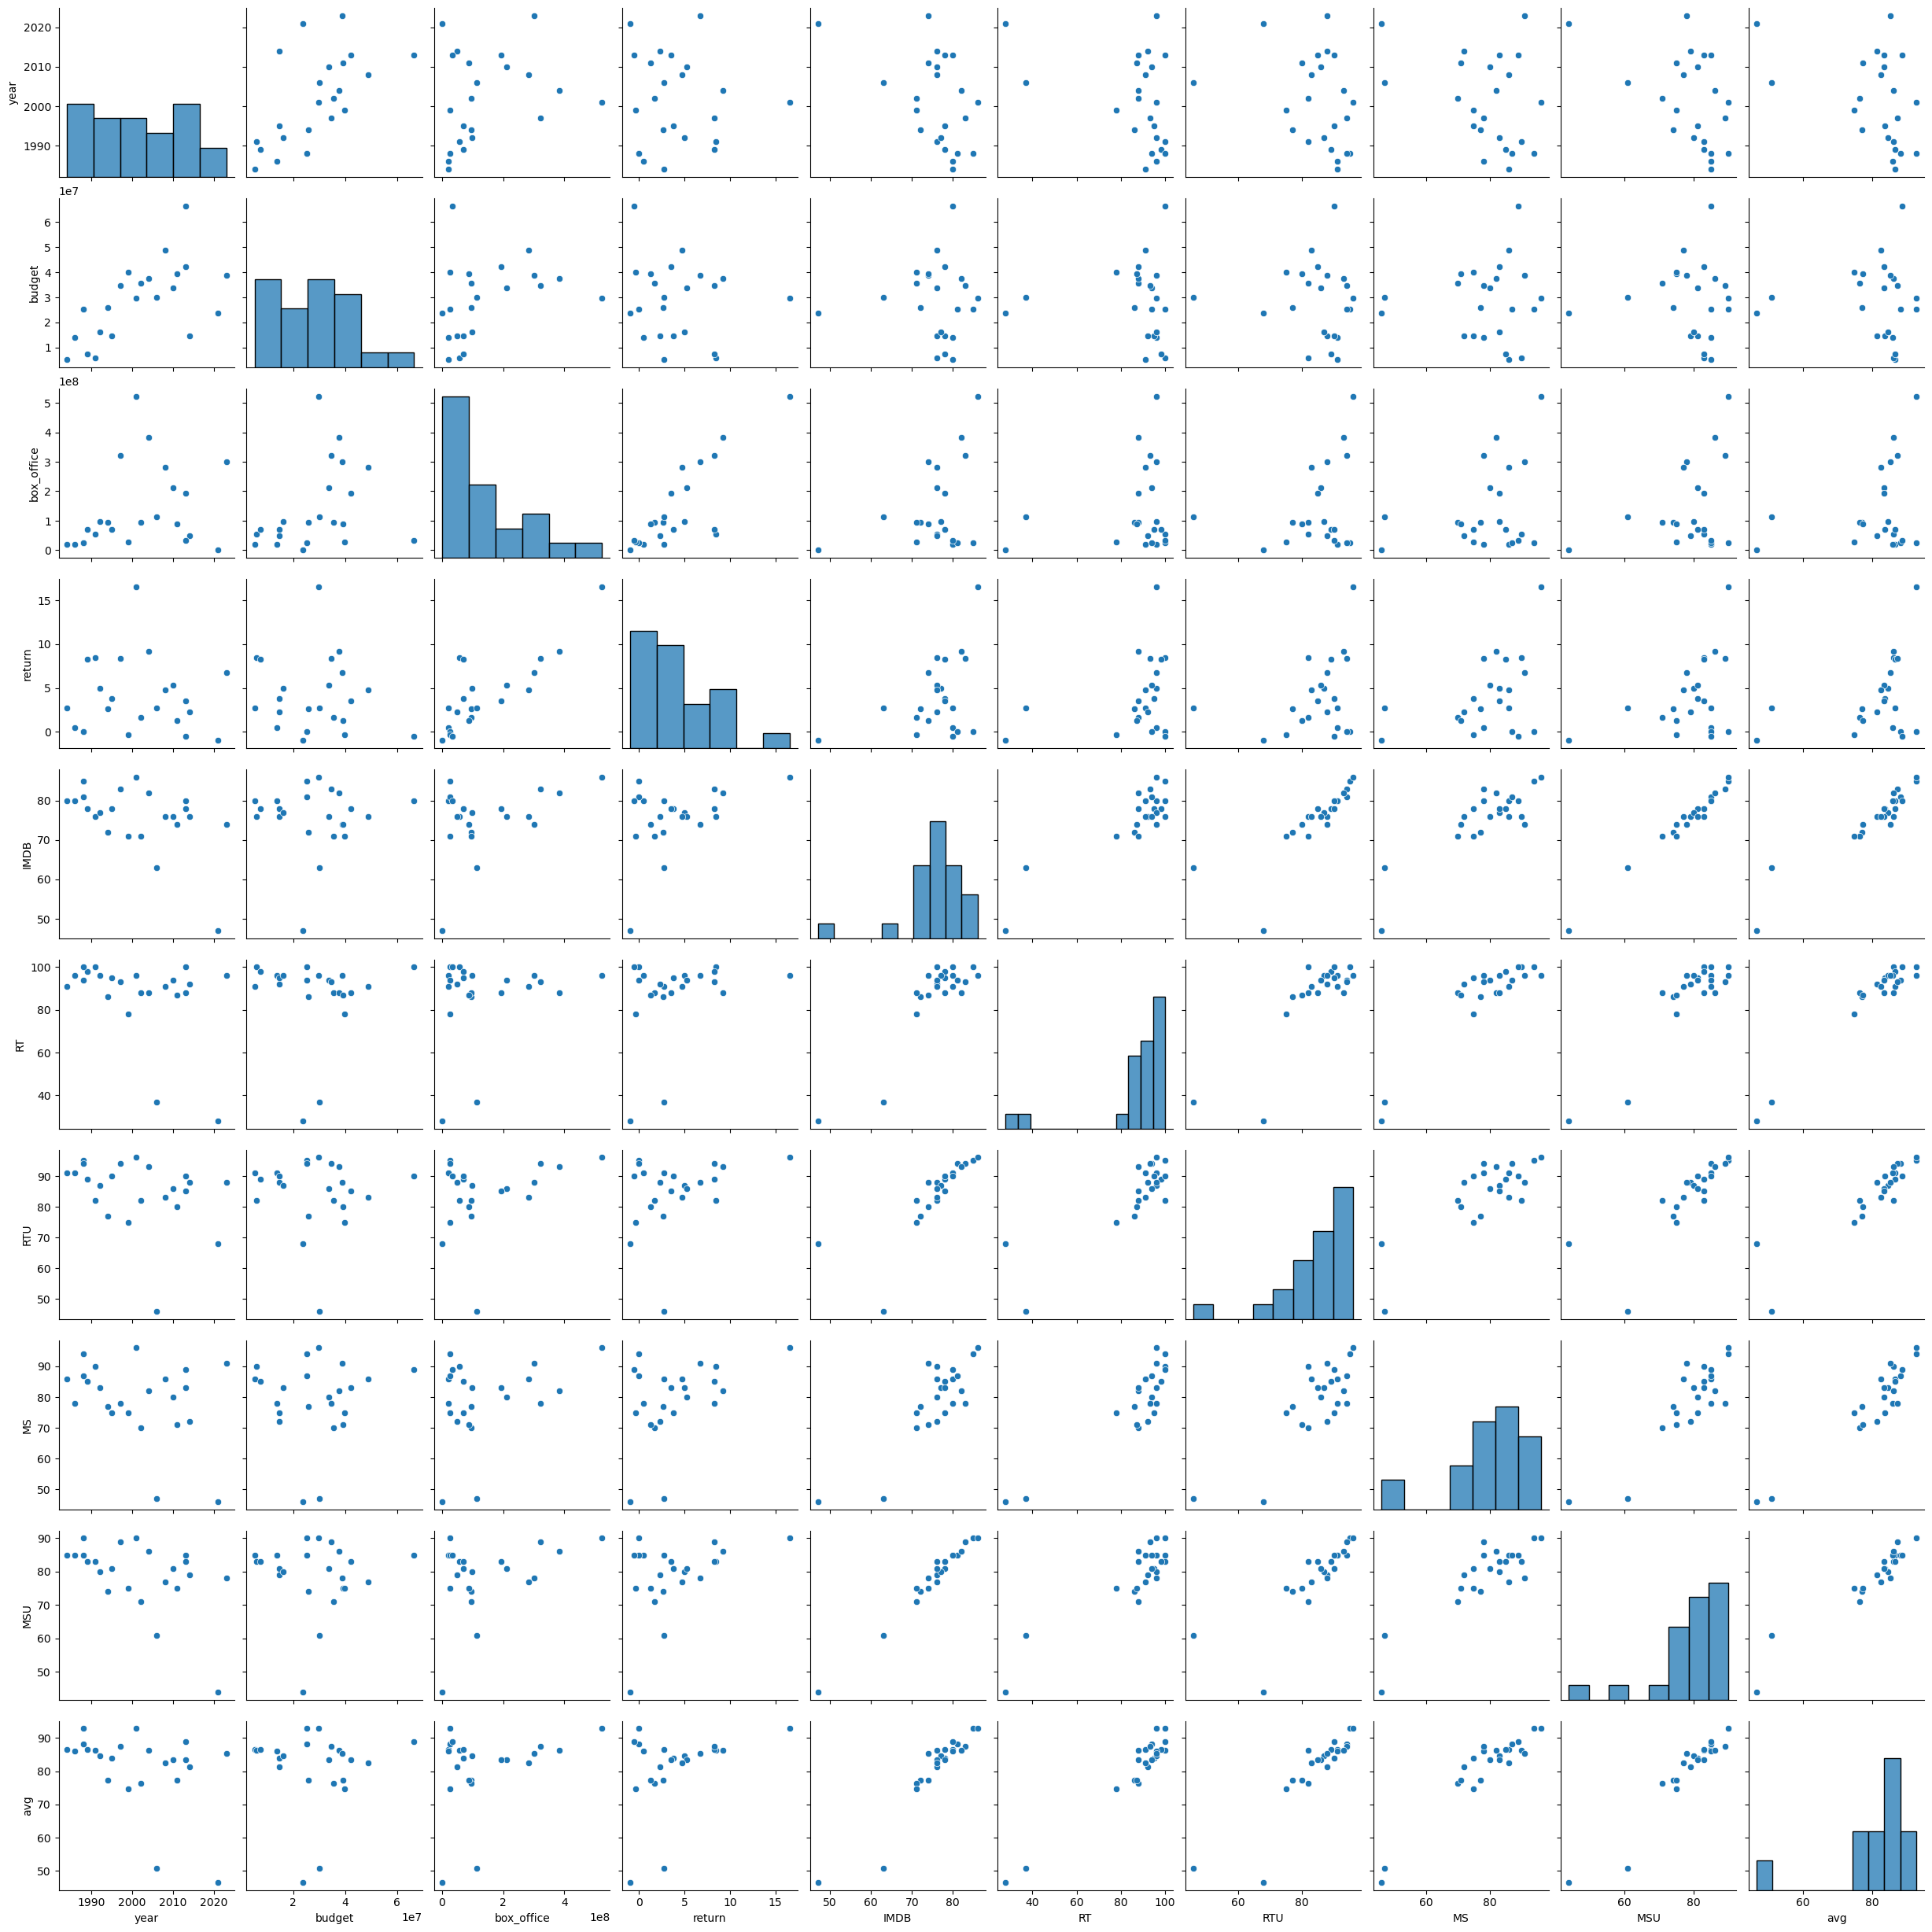

In [38]:
import seaborn as sns
sns.pairplot(masterghibli); # for future cell runs, this is a chunky command

Notice the reviews are particularly strong, so which review aggregator is the closest?
We measure this by performing LSR between each website and the average scores, and finding the best r^2.

In [171]:
sites = ['IMDB', 'RT', 'RTU', 'MS', 'MSU']
mast = 0
indie = 'IMDB'
for x in range(22):
    for i in sites:
        targ = masterghibli.loc[x,i]
        diff = np.abs(masterghibli.loc[x, 'avg'] - targ)
        if diff > mast:
            mast = diff
            indie = i
    print(f"{masterghibli.iloc[x]['movie']} Biggest Difference:\n{indie}: {diff:.2}\n")

Nausicaa Biggest Difference:
IMDB: 1.6

Only Yesterday Biggest Difference:
RT: 3.2

Kiki's Delivery Service Biggest Difference:
RT: 3.6

Castle in the Sky Biggest Difference:
RT: 1.0

Whisper of the Heart Biggest Difference:
RT: 2.8

When Marnie Was There Biggest Difference:
RT: 2.4

Porco Rosso Biggest Difference:
RT: 4.6

Earwig and the Witch Biggest Difference:
RTU: 2.6

Grave of the Fireflies Biggest Difference:
RTU: 2.8

My Neighbor Totoro Biggest Difference:
RTU: 3.2

Pom Poko Biggest Difference:
RTU: 3.2

Spirited Away Biggest Difference:
RTU: 2.8

Tales from Earthsea Biggest Difference:
RTU: 1e+01

Arrietty Biggest Difference:
RTU: 2.4

Princess Mononoke Biggest Difference:
RTU: 1.6

The Cat Returns Biggest Difference:
RTU: 5.4

Howl's Moving Castle Biggest Difference:
RTU: 0.2

The Boy and the Heron Biggest Difference:
RTU: 7.4

From Up On Poppy Hill Biggest Difference:
RTU: 2.4

My Neighbors the Yamadas Biggest Difference:
RTU: 0.2

The Wind Rises Biggest Difference:
RTU: 0.4

# Conclusion
All sites are very good predictors of the average, but in order from best to worst:
1. Metacritic Users
2. IMDB
3. Metacritic
4. Rotten Tomatoes Users
5. Rotten Tomatoes

In [39]:
masterghibli.sort_values('MSU', ascending=False)

,movie,release_date,year,budget,box_office,return,IMDB,RT,RTU,MS,MSU,avg,director,genre,genre1,genre2
11,Spirited Away,2001-07-20,2001,29752755.99,5.227044e+08,16.568269,86.0,96,96,96,90.0,92.8,Hayao Miyazaki,fantasy,fantasy,None
8,Grave of the Fireflies,1988-04-15,1988,25352660.50,2.535266e+07,0.000000,85.0,100,95,94,90.0,92.8,Isao Takahata,war,war,None
14,Princess Mononoke,1997-07-12,1997,34606599.41,3.226360e+08,8.322961,83.0,93,94,78,89.0,87.4,Hayao Miyazaki,"historical, fantasy",historical,fantasy
16,Howl's Moving Castle,2004-11-20,2004,37622834.55,3.835464e+08,9.194512,82.0,88,93,82,86.0,86.2,Hayao Miyazaki,fantasy,fantasy,None
9,My Neighbor Totoro,1988-04-15,1988,25352660.50,2.535266e+07,0.000000,81.0,94,94,87,85.0,88.2,Hayao Miyazaki,fantasy,fantasy,None
0,Nausicaa,1984-03-11,1984,5192590.62,1.947221e+07,2.750000,80.0,91,91,86,85.0,86.6,Hayao Miyazaki,"post-apocalyptic, fantasy",post-apocalyptic,fantasy
3,Castle in the Sky,1986-08-02,1986,13883332.51,2.082500e+07,0.500000,80.0,96,91,78,85.0,86.0,Hayao Miyazaki,"fantasy, adventure",fantasy,adventure
22,The Tale of Princess Kaguya,2013-11-23,2013,66521167.01,3.386080e+07,-0.490977,80.0,100,90,89,85.0,88.8,Isao Takahata,"historical, fantasy",historical,fantasy
1,Only Yesterday,1991-07-20,1991,5878275.10,5.555514e+07,8.450925,76.0,100,82,90,83.0,86.2,Isao Takahata,drama,drama,None
2,Kiki's Delivery Service,1989-07-29,1989,7483696.66,6.922419e+07,8.250000,78.0,98,89,85,83.0,86.6,Hayao Miyazaki,fantasy,fantasy,None
